In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex

In [2]:
df= pd.read_csv(r'OpTransactionHistory27-11-2022.csv')

In [3]:
def extracting(row, n) -> str | None:
    try:
        return str(row["Particulars"]).split('/')[n]
    except:
        return None


df["Month"] = df.apply(lambda row: pd.to_datetime(
    row['Transaction Date']).month, axis=1)
df['Withdrawals'] = df['Withdrawals'].str.replace(',', '')
df['Deposits'] = df['Deposits'].str.replace(',', '')
df['Balance Amount'] = df['Balance Amount'].str.replace(',', '')
df = df.astype({"Withdrawals":'float',"Deposits":'float',"Balance Amount":"float"})
df["UPIid"] = df.apply(lambda row: extracting(row,-1), axis=1)
df["Name"] = df.apply(lambda row: extracting(row,3), axis=1)

In [4]:
outliers = df[(df['Withdrawals'] >=10000) | (df['Deposits'] >= 10000)]
print(outliers)
df.drop(outliers.index , inplace=True)
#outliers

      SlNo Transaction Date   Value Date  \
2      3.0      18-Jun-2022  18-Jun-2022   
3      4.0      18-Jun-2022  18-Jun-2022   
284  285.0      26-Sep-2022  26-Sep-2022   

                              Particulars  Unnamed: 4 Unnamed: 5  \
2            BY CASH BR:BIDADI/CCEPN8833J         NaN        NaN   
3                  NEFT:KING HYDROPONICS/         NaN        NaN   
284  Dr. Tran for funding A/c ZZ37342506/         NaN        NaN   

     Cheque Number  Withdrawals  Deposits  Balance Amount  Month       UPIid  \
2              NaN          NaN  100000.0       100010.25    6.0  CCEPN8833J   
3              NaN          NaN   26500.0       126510.25    6.0               
284            NaN     100000.0       NaN         6476.07    9.0               

     Name  
2    None  
3    None  
284  None  


In [5]:
big_transactions = df[(df['Withdrawals'] >=500) | (df['Deposits'] >= 500)]
big_transactions.sort_values(by=['Withdrawals','Deposits'], ascending=False)
big_transactions.count()

SlNo                48
Transaction Date    48
Value Date          48
Particulars         48
Unnamed: 4           0
Unnamed: 5           0
Cheque Number        0
Withdrawals         27
Deposits            21
Balance Amount      48
Month               48
UPIid               48
Name                47
dtype: int64

In [6]:
monthly = df.groupby('Month',as_index=False).agg({"Withdrawals": "sum", "Deposits": "sum", "Balance Amount": "mean"})
monthly["Expenditure"]=monthly.apply(lambda row: row["Withdrawals"] - row["Deposits"],axis=1)
monthly = monthly.sort_values(by="Expenditure")
monthly["Expenditure"].sum()
monthly=monthly.sort_index()



<AxesSubplot:title={'center':'Monthly Expenditure'}, xlabel='Month', ylabel='Rupees'>

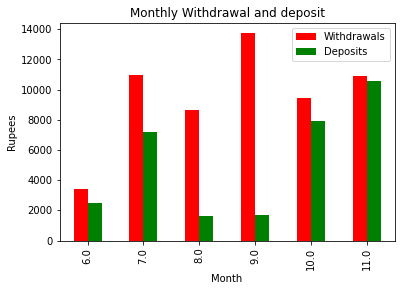

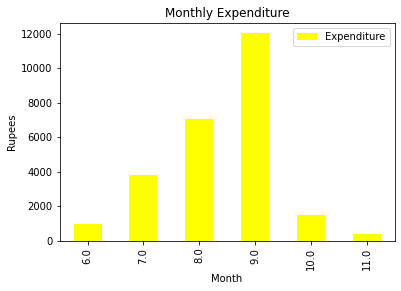

In [7]:
monthly.plot(x='Month',y=['Withdrawals','Deposits'],kind='bar', color=['red','green'],title='Monthly Withdrawal and deposit', ylabel = 'Rupees')
monthly.plot(x='Month',y='Expenditure',kind='bar', color='yellow',title='Monthly Expenditure', ylabel = 'Rupees')

In [8]:
#df[df['Particulars'].str.contains("Ranjith | LAVANYA | Lavanya ",na=False, case=False, regex=True)]["Withdrawals"].sum()

In [8]:
df.head(100)

,SlNo,Transaction Date,Value Date,Particulars,Unnamed: 4,Unnamed: 5,Cheque Number,Withdrawals,Deposits,Balance Amount,Month,UPIid,Name
0,1.0,18-Jun-2022,18-Jun-2022,UPI/SBIN/216910094455/SREELEKHA S/UPI/SBIce0b...,NaN,NaN,NaN,NaN,1000.0,1010.25,6.0,sreelekha.s.sa,SREELEKHA S
1,2.0,18-Jun-2022,18-Jun-2022,UPI/SBIN/216990141498/SUNITHA NORONHA/UPI/ICI...,NaN,NaN,NaN,1000.0,NaN,10.25,6.0,sonuolive777@o,SUNITHA NORONHA
4,5.0,21-Jun-2022,21-Jun-2022,UPI/YESB/217251515787/Nandini/UPI/ICIebaf445c2...,NaN,NaN,NaN,185.0,NaN,126325.25,6.0,q45644524@ybl,Nandini
5,6.0,21-Jun-2022,21-Jun-2022,UPI/UTIB/217217319053/CHANDRASHEKAR T E/UPI/IC...,NaN,NaN,NaN,300.0,NaN,126025.25,6.0,q253303725@ybl,CHANDRASHEKAR T E
6,7.0,21-Jun-2022,21-Jun-2022,UPI/KKBK/217299623992/JOHN B NORONHA/UPI/ICIe1...,NaN,NaN,NaN,NaN,1500.0,127525.25,6.0,serviceexpert1,JOHN B NORONHA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,98.0,01-Aug-2022,01-Aug-2022,UPI/ICIC/221339275544/billdesktez/UPI/ICI05baa...,NaN,NaN,NaN,479.0,NaN,121298.47,8.0,billdesk.prepa,billdesktez
98,99.0,01-Aug-2022,01-Aug-2022,UPI/PYTM/221392385309/JOMON C JOSEPH/UPI/ICIb4...,NaN,NaN,NaN,30.0,NaN,121268.47,8.0,paytmqr2810050,JOMON C JOSEPH
99,100.0,01-Aug-2022,01-Aug-2022,UPI/PYTM/221337287899/JOMON C JOSEPH/UPI/ICIde...,NaN,NaN,NaN,70.0,NaN,121198.47,8.0,paytmqr2810050,JOMON C JOSEPH
100,101.0,01-Aug-2022,01-Aug-2022,UPI/PYTM/221316895296/JOMON C JOSEPH/UPI/ICI20...,NaN,NaN,NaN,20.0,NaN,121178.47,8.0,paytmqr2810050,JOMON C JOSEPH


In [9]:
particularly = df.groupby("Name").agg(
    {"Withdrawals": "sum", "Deposits": "sum", "Balance Amount": "mean"})
particularly["Expenditure"] = particularly.apply(
    lambda row: row["Withdrawals"] - row["Deposits"], axis=1)
particularly=particularly.sort_values(by="Expenditure")
particularly["Expenditure"].sum()
particularly

,Withdrawals,Deposits,Balance Amount,Expenditure
Name,,,,
JOHN BAPTIST NORONHA,0.0,13501.0,42325.543333,-13501.0
SUNITHA NORONHA,1000.0,9500.0,26602.375556,-8500.0
JOHN B NORONHA,0.0,1500.0,127525.250000,-1500.0
SREELEKHA S,0.0,1000.0,1010.250000,-1000.0
ANANYA UNIYAL,1887.0,2519.0,1320.135455,-632.0
...,...,...,...,...
AAKANKSHA SUNDAR,2034.0,0.0,78310.936667,2034.0
JOMON C JOSEPH,2301.0,0.0,89474.597013,2301.0
DEEPANJALI SERVICE S,2710.0,0.0,66820.492857,2710.0


In [10]:
parents = df.groupby(['Month','Name'],as_index=False).agg({"Withdrawals": "sum", "Deposits": "sum", "Balance Amount": "mean"})
parents["Expenditure"]=parents.apply(lambda row: row["Deposits"] - row["Withdrawals"],axis=1)
parents_dad = parents[parents['Name'].str.contains("JOHN B|APTIST NORONHA", na=False, case=False, regex=True)]
parents_mom = parents[parents['Name'].str.contains(particularly.index[1], na=False, case=False, regex=True)]
parents_mom

,Month,Name,Withdrawals,Deposits,Balance Amount,Expenditure
12,6.0,SUNITHA NORONHA,1000.0,0.0,10.250000,-1000.0
37,7.0,SUNITHA NORONHA,0.0,1000.0,124420.470000,1000.0
77,8.0,SUNITHA NORONHA,0.0,500.0,115681.170000,500.0
127,9.0,SUNITHA NORONHA,0.0,1000.0,114323.670000,1000.0
180,10.0,SUNITHA NORONHA,0.0,6000.0,630.806364,6000.0
218,11.0,SUNITHA NORONHA,0.0,1000.0,1572.330000,1000.0
